In [2]:
import importlib
import os
import sys
sys.path.append("/cluster/u/rrastogi/ECNN/X-CAP/src/utils")

import evaluation_utils
importlib.reload(evaluation_utils)
from evaluation_utils import *
from evaluation_utils import get_cadd_predictions

from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
import lightgbm as lgb

DEFAULT_XCAP_CLF_PATH = "/cluster/u/rrastogi/ECNN/results/d_original/xcap/featurize_0520/clf.mdl"
XCAP_TRAINED_ON_ALOFT_DATA_CLF_PATH = "aloft/clf_augment.mdl"
XCAP_TRAINED_ON_MUTPRED_DATA_CLF_PATH = "mutpred/clf_augment.mdl"

In [3]:
default_xcap_clf = lgb.Booster(model_file=DEFAULT_XCAP_CLF_PATH)
xcap_trained_on_aloft_data_clf = lgb.Booster(model_file=XCAP_TRAINED_ON_ALOFT_DATA_CLF_PATH)
xcap_trained_on_mutpred_data_clf = lgb.Booster(model_file=XCAP_TRAINED_ON_MUTPRED_DATA_CLF_PATH)

In [4]:
def plotRocHelper(labels, predictions, clf_name, legend, hsr, main_line=True):
    fpr, tpr, _ = roc_curve(labels, predictions)
    auroc = auc(fpr, tpr) if not hsr else getHsrAuc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle=':' if main_line else '-')
    legend.append("{}: {:0.3f}".format(clf_name, round(auroc, 3)))

def create_title(metric):
    dataset = "$D_{original}$"
    return "{} ({})".format(metric, dataset)

def plotRoc(hsr=False):
    plt.figure(figsize=(6, 5), dpi=300)
    
    results_dir = "/cluster/u/rrastogi/ECNN/results/d_original"
    xcap_features_path = os.path.join(results_dir, "xcap/featurize_0520/total_test.features")
    aloft_results_path = os.path.join(results_dir, "aloft/total/aloft_output/hg19.aloft.lof.results")
    aloft_hg38_vcf_path = os.path.join(results_dir, "aloft/total/hg38.vcf")
    mutpred_input_path = os.path.join(results_dir, "mutpred/total/subset.tsv")
    mutpred_results_path = os.path.join(results_dir, "mutpred/total/results_output.txt")
    wgp_input_path = os.path.join(results_dir, "preprocess/collate/total_test.tsv")
    wgp_results_path = os.path.join(results_dir, "wgp/total/avinput.hg38_multianno.txt")

    legend = []

    # Default X-CAP
    xcap_labels, xcap_predictions = get_xcap_predictions(default_xcap_clf, xcap_features_path)
    plotRocHelper(xcap_labels, xcap_predictions, "X-CAP (original)", legend, hsr, main_line=False)
    
    # X-CAP (trained on MutPred-LoF data)
    xcap_labels, xcap_predictions = get_xcap_predictions(xcap_trained_on_mutpred_data_clf, xcap_features_path)
    plotRocHelper(xcap_labels, xcap_predictions, "X-CAP (trained on MutPred-LoF data)", legend, hsr)
    
    # X-CAP (trained on ALoFT data)
    xcap_labels, xcap_predictions = get_xcap_predictions(xcap_trained_on_aloft_data_clf, xcap_features_path)
    plotRocHelper(xcap_labels, xcap_predictions, "X-CAP (trained on ALoFT data)", legend, hsr)
    
    # AloFT
    aloft_labels, aloft_predictions, _ = get_aloft_predictions(aloft_results_path, aloft_hg38_vcf_path)
    plotRocHelper(aloft_labels, aloft_predictions, "ALoFT", legend, hsr, main_line=False)

    # MutPred-LoF
    mutpred_labels, mutpred_predictions = get_mutpred_predictions(mutpred_input_path, mutpred_results_path)
    plotRocHelper(mutpred_labels, mutpred_predictions, "MutPred-LoF", legend, hsr, main_line=False)
    
    # CADD
    cadd_labels, cadd_predictions = get_cadd_predictions(wgp_input_path, wgp_results_path)
    plotRocHelper(cadd_labels, cadd_predictions, "CADD", legend, hsr, main_line=False)
    
    # DANN
    dann_labels, dann_predictions = get_dann_predictions(wgp_input_path, wgp_results_path)
    plotRocHelper(dann_labels, dann_predictions, "DANN", legend, hsr, main_line=False)
    
    # Eigen
    eigen_labels, eigen_predictions = get_eigen_predictions(wgp_input_path, wgp_results_path)
    plotRocHelper(eigen_labels, eigen_predictions, "Eigen", legend, hsr, main_line=False)
    
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0] if not hsr else [0.95, 1.0])
    plt.title(create_title("hsr-ROC" if hsr else "ROC"))
    plt.legend(legend, loc="upper left" if hsr else "lower right")
    plt.show()

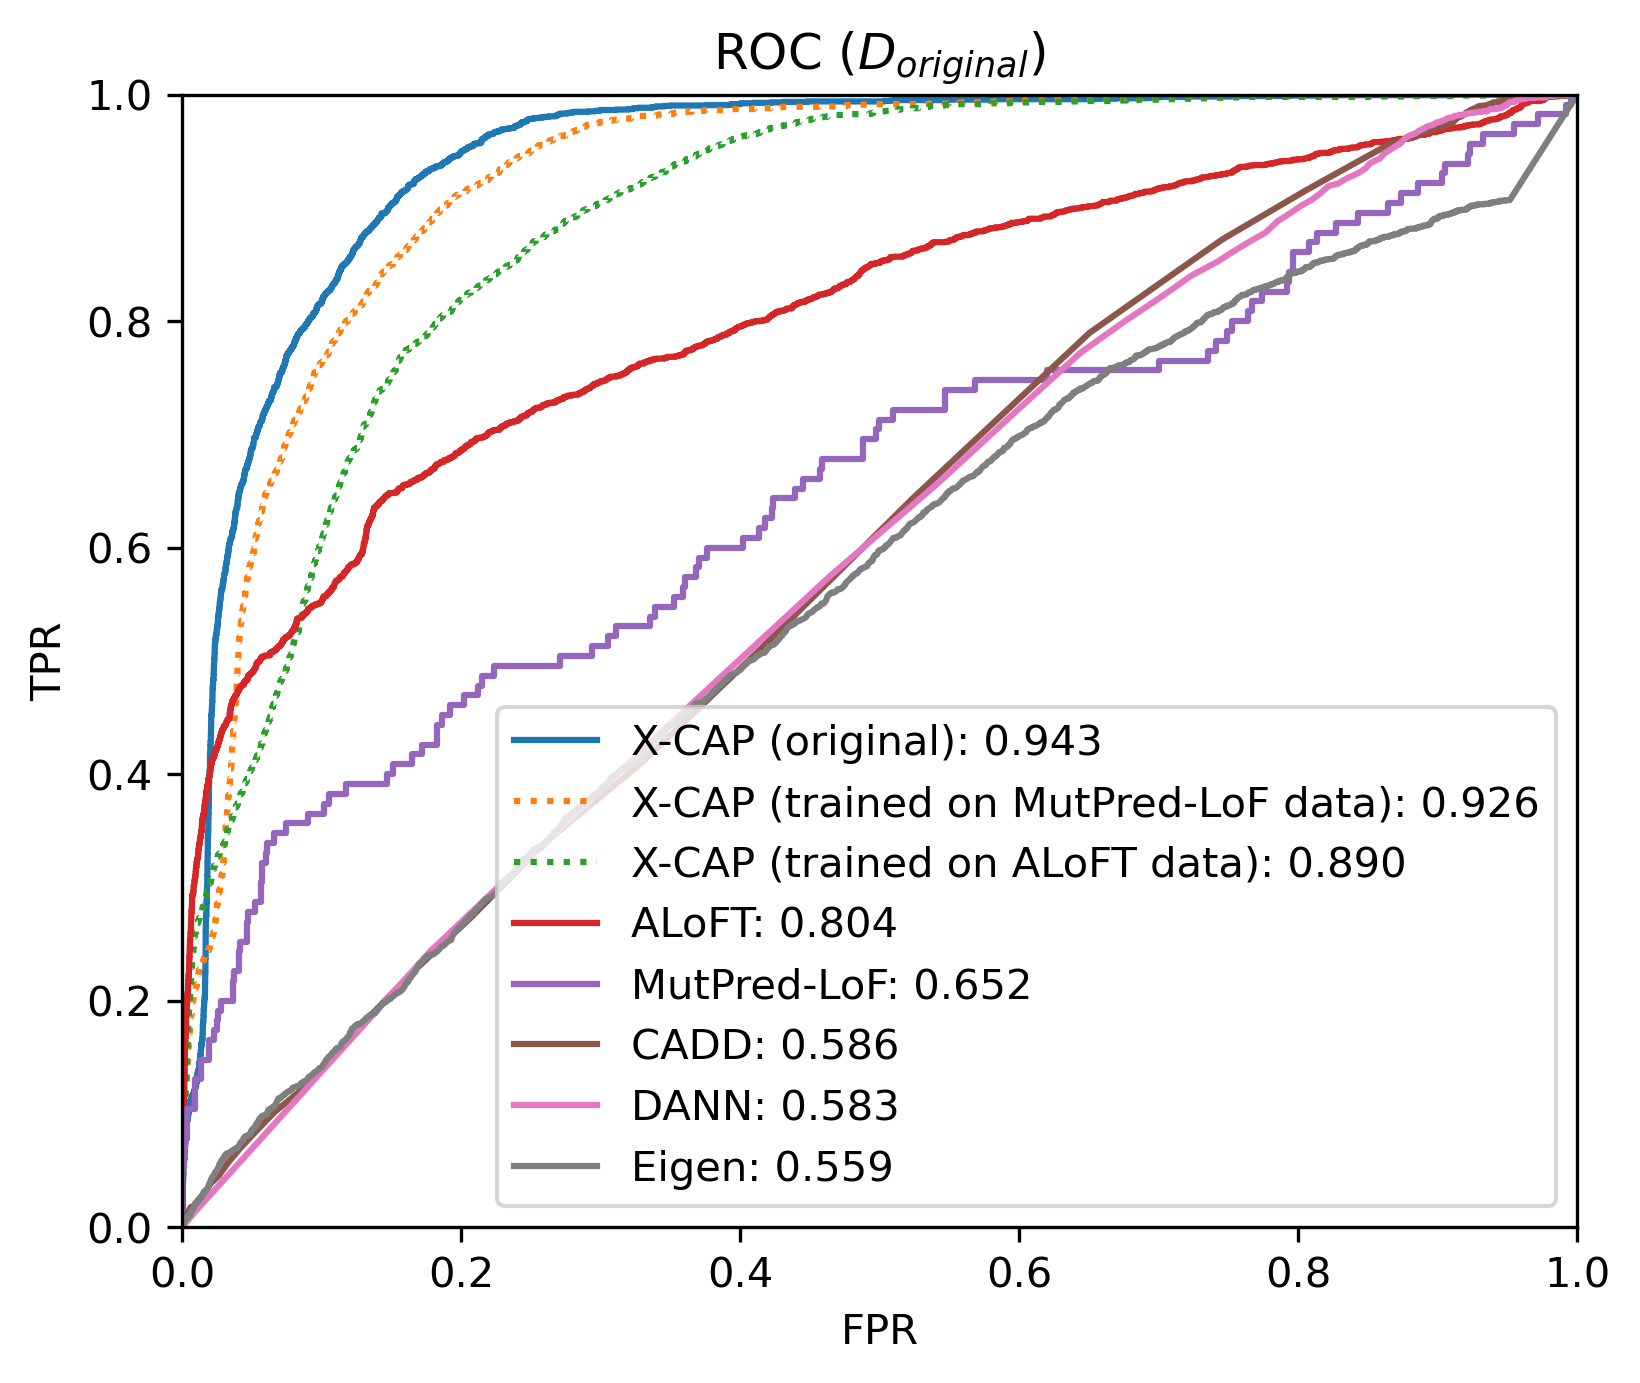

In [5]:
plotRoc()

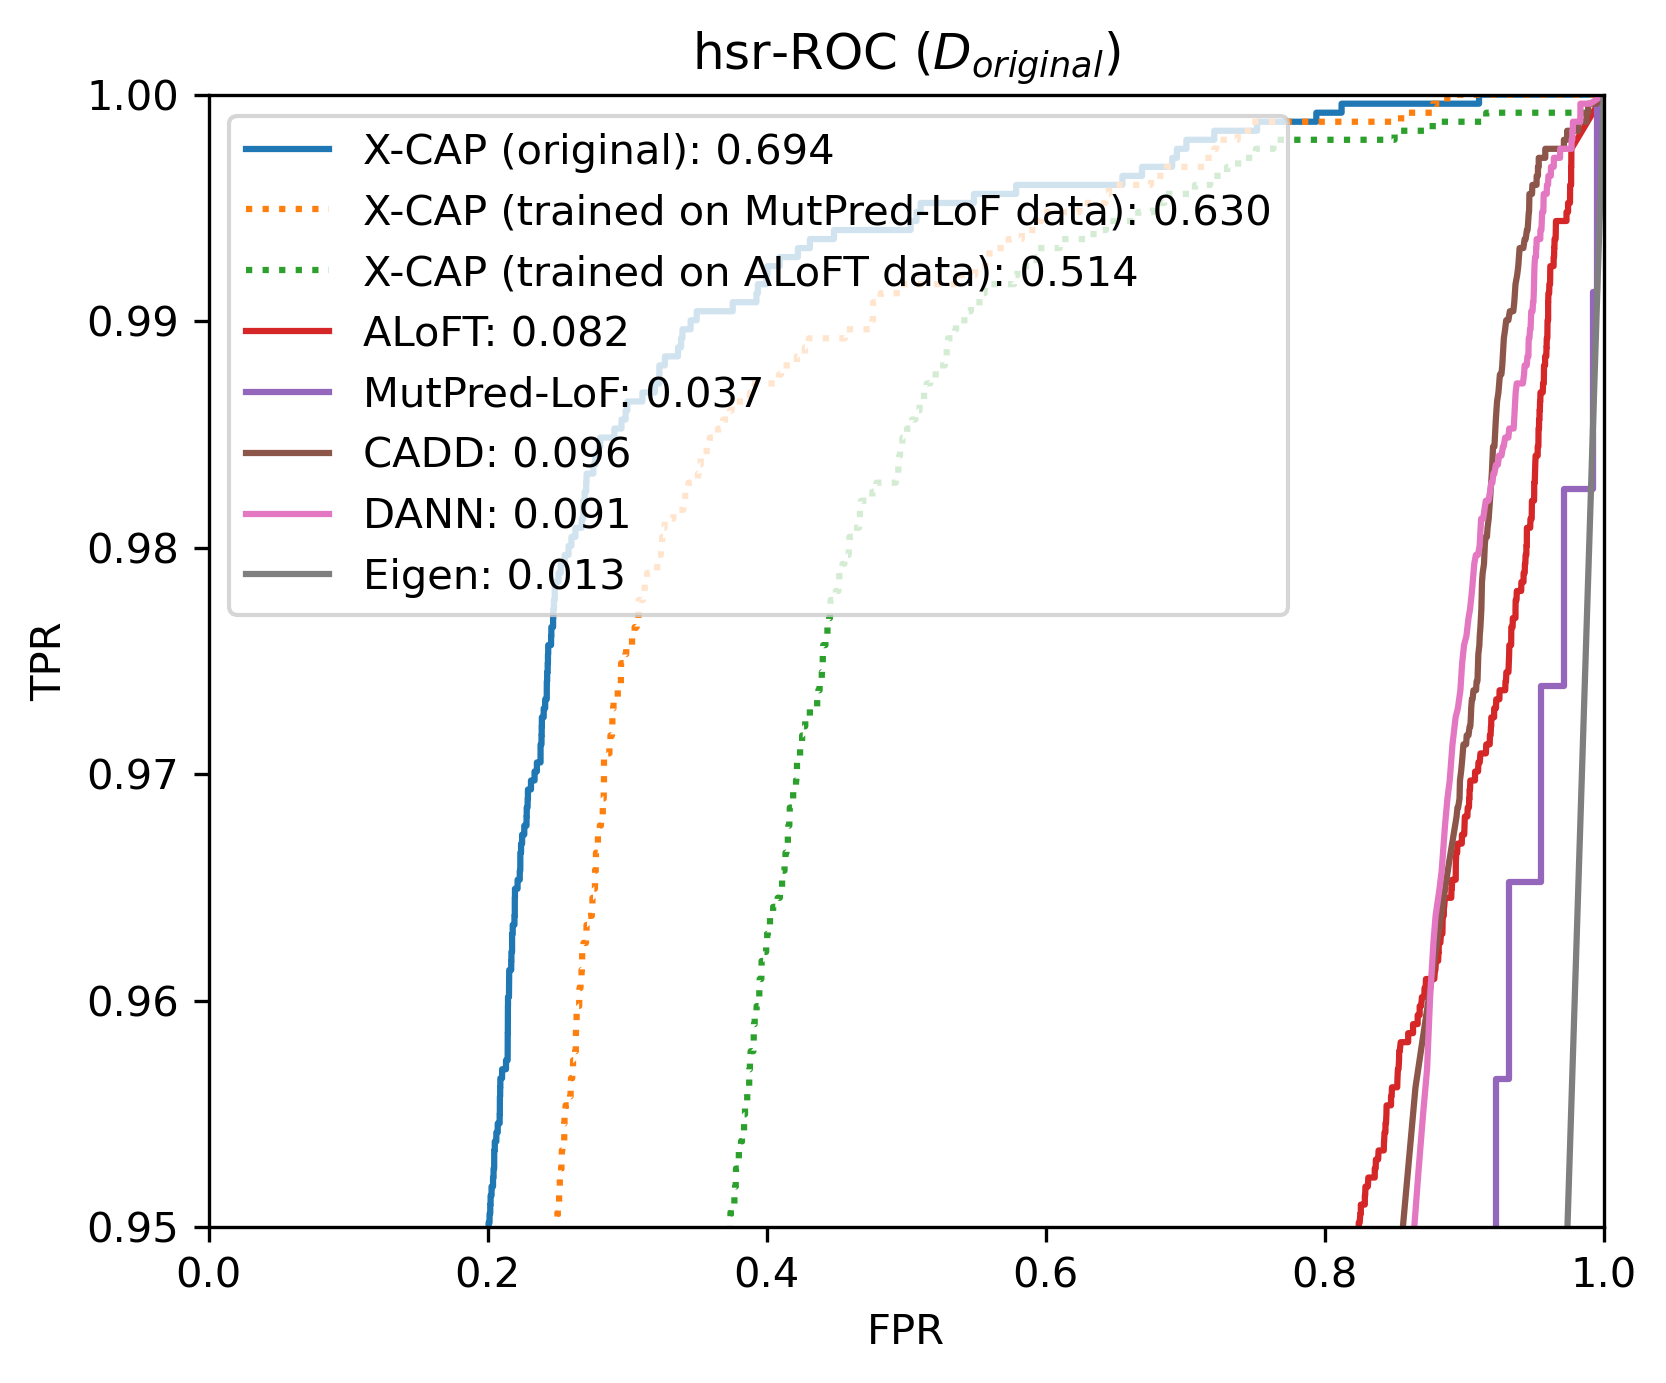

In [6]:
plotRoc(hsr=True)